In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cosine
from sktime.datasets import load_airline
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sktime.transformations.series.detrend import Detrender
from sktime.transformations.series.detrend import Deseasonalizer
from sktime.pipeline import make_pipeline

In [2]:
def load_npy(filename):
    return np.load(filename)

# Identifying threshold

In [3]:
import os
dir_path = 'time_series/'
len_threshold = 1400

In [4]:
X, y, ids = [], [], []
genres = []
genre_count = {}  # Track the number of samples extracted for each genre

for file in os.listdir(dir_path):
    if os.path.splitext(file)[1] != '.npy':
        continue

    split = file.split("_")
    track_id = split[0]
    genre = split[1][:-4]
    
    if genre not in genre_count:
        genre_count[genre] = 0
    
    if genre_count[genre] >= 100:
        continue  # Skip if already extracted 100 samples for this genre
    
    ids.append(track_id)
    y.append(genre)
    genres.append(split)
    ts = np.load(os.path.join(dir_path, file))
    
    if len(ts) > len_threshold: 
        ts = ts[:len_threshold]  # Truncate if longer
    else:
        pad = [ts[-1]] * (len_threshold - len(ts))  # Fill with last observation 
        ts = np.append(ts, pad) 

    X.append([ts])
    genre_count[genre] += 1

X, y, ids = np.array(X), np.array(y), np.array(ids)

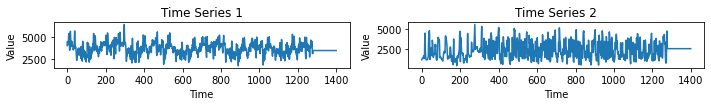

In [5]:
# Plot the first 10 time series
plt.figure(figsize=(10, 6))
for i in range(2):
    plt.subplot(5, 2, i+1)  # 5 rows, 2 columns, i+1 is the plot index
    plt.plot(X[i][0])  # Assuming X is a list of lists where each inner list contains a single time series
    plt.title(f"Time Series {i+1}")
    plt.xlabel("Time")
    plt.ylabel("Value")
plt.tight_layout()
plt.show()

### We can note no info after 1200...so we set 1280 as treshold

In [6]:
len_threshold = 1280   #cause >1280 no infos in ts 

# Loading TS

In [7]:
X, y, ids = [], [], []
genres = []
genre_count = {}  # Track the number of samples extracted for each genre

for file in os.listdir(dir_path):
    if os.path.splitext(file)[1] != '.npy':
        continue

    split = file.split("_")
    track_id = split[0]
    genre = split[1][:-4]
    
    if genre not in genre_count:
        genre_count[genre] = 0
    
    if genre_count[genre] >= 100:
        continue  # Skip if already extracted 100 samples for this genre
    
    ids.append(track_id)
    y.append(genre)
    genres.append(split)
    ts = np.load(os.path.join(dir_path, file))
    
    if len(ts) > len_threshold: 
        ts = ts[:len_threshold]  # Truncate if longer
    else:
        pad = [ts[-1]] * (len_threshold - len(ts))  # Fill with last observation 
        ts = np.append(ts, pad) 

    X.append([ts])
    genre_count[genre] += 1

X, y, ids = np.array(X), np.array(y), np.array(ids)

In [8]:
second_elements = [item[1] for item in genres]

unique_elements = list(set([element.replace('.npy', '') for element in second_elements]))
print(unique_elements)
len(unique_elements)

['piano', 'progressive-house', 'sleep', 'kids', 'synth-pop', 'salsa', 'world-music', 'songwriter', 'heavy-metal', 'goth', 'minimal-techno', 'sertanejo', 'j-idol', 'mpb', 'emo', 'new-age', 'opera', 'happy', 'honky-tonk', 'folk']


20

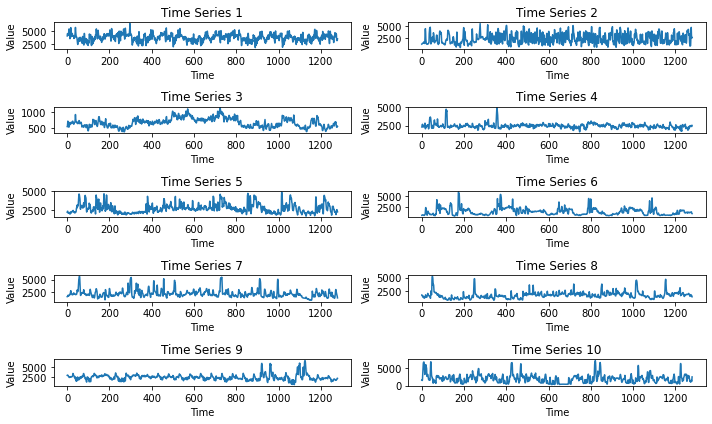

In [9]:
# Plot the first 10 time series
plt.figure(figsize=(10, 6))
for i in range(10):
    plt.subplot(5, 2, i+1)  # 5 rows, 2 columns, i+1 is the plot index
    plt.plot(X[i][0])  # Assuming X is a list of lists where each inner list contains a single time series
    plt.title(f"Time Series {i+1}")
    plt.xlabel("Time")
    plt.ylabel("Value")
plt.tight_layout()
plt.show()

# Trasformazioni (amplitude scaling, noise)  win size= 100

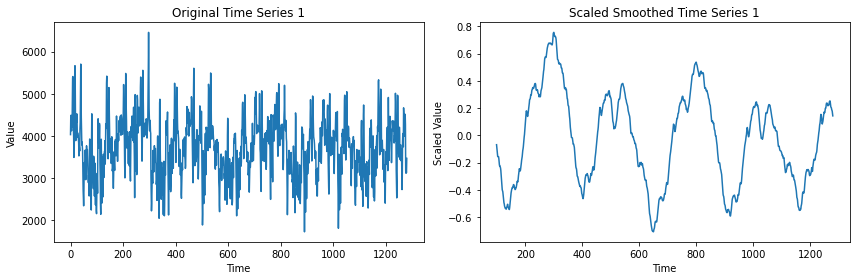

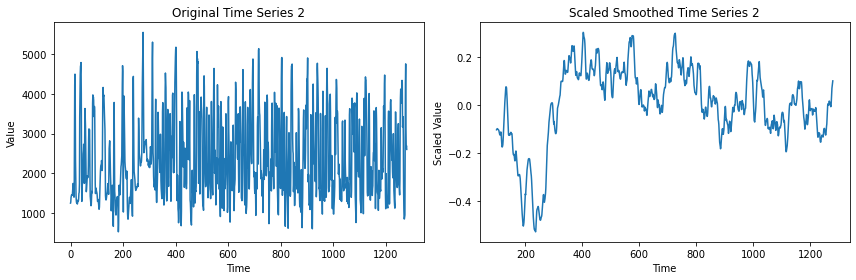

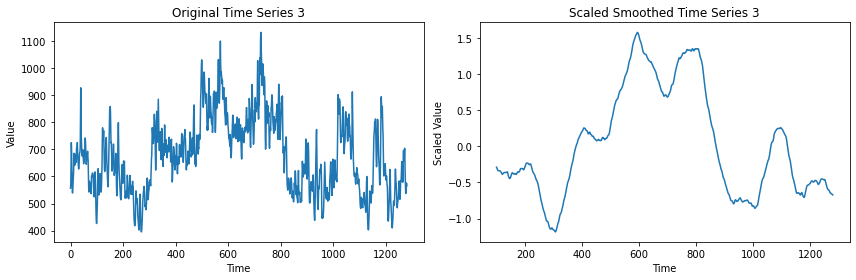

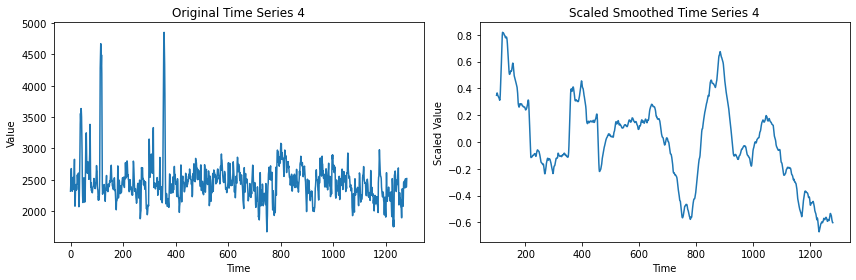

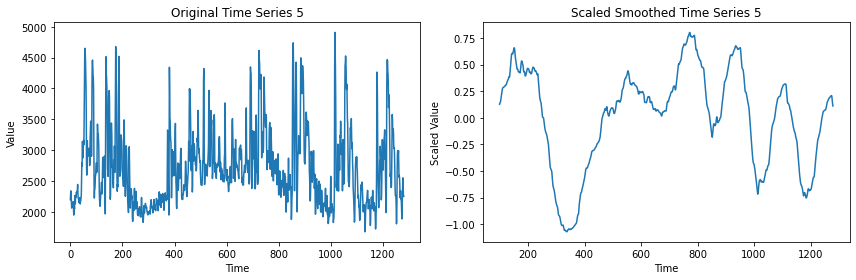

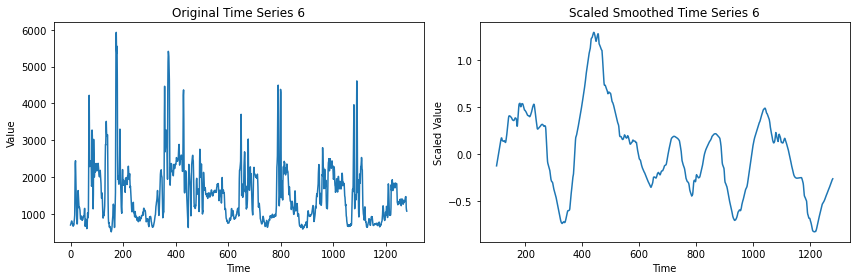

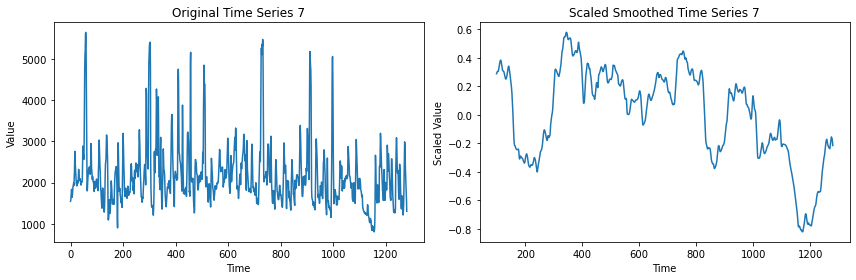

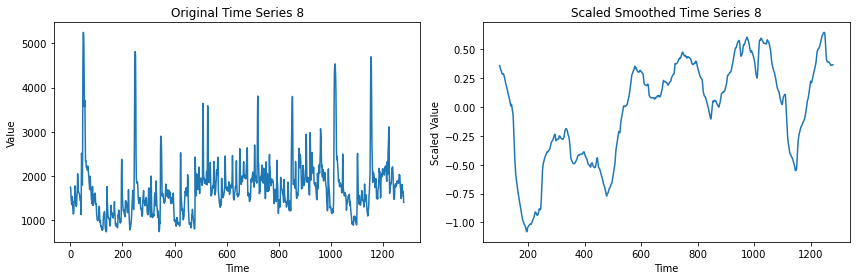

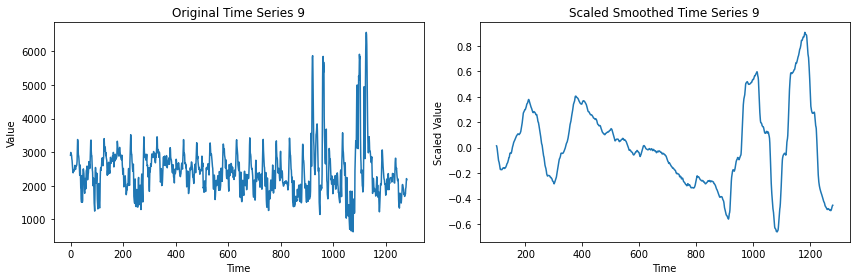

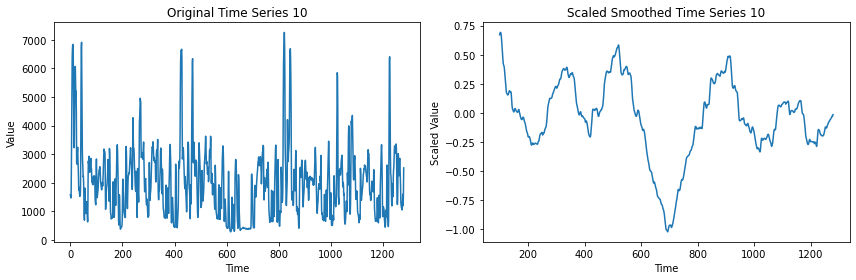

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Define window size for rolling mean
w = 150

# Assume X contains the time series data for the first 10 time series
scaler = StandardScaler()

for i in range(10):
    ts = X[i][0]  # Assuming X is a list of lists where each inner list contains a single time series
    
    # Scale the time series
    tss = scaler.fit_transform(np.array(ts).reshape(-1, 1))
    
    # Mean centering and standardization
    ts_scaled = ((tss - tss.mean()) / tss.std())
    
    # Apply rolling window mean
    ts_smoothed = pd.Series(ts_scaled.squeeze()).rolling(window=w).mean()
    
    # Plot comparison subplot
    plt.figure(figsize=(12, 4))
    
    # Plot original time series
    plt.subplot(1, 2, 1)
    plt.plot(ts)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title(f"Original Time Series {i+1}")
    
    # Plot scaled and smoothed time series
    plt.subplot(1, 2, 2)
    plt.plot(ts_smoothed)
    plt.xlabel("Time")
    plt.ylabel("Scaled Value")
    plt.title(f"Scaled Smoothed Time Series {i+1}")
    
    plt.tight_layout()
    plt.show()


In [11]:
from sktime.transformations.panel.dictionary_based import PAA

# Reconstruct Error on PAA approx

In [12]:
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler

# Define your time series data in X

# Define window size for rolling mean
w_values = [5, 10, 100, 150, 180, 250]

original_series_list = []
scaled_series_list = []
smoothed_series_list = []
euclidean_distance_list = []

min_distance = float('inf')  # Initialize min_distance with infinity
best_w = None

for w in w_values:
    scaled_series_per_w = []  # List to store scaled series for the current window size
    smoothed_series_per_w = []  # List to store smoothed series for the current window size
    original_series_per_w = []  # List to store reconstructed series for the current window size
    
    distance_sum = 0
    for i in range(len(X)):
        ts = X[i][0]  # Assuming X is a list of time series
        
        # Scale the time series
        scaler = StandardScaler()
        tss = scaler.fit_transform(np.array(ts).reshape(-1, 1))
        
        # Mean centering and standardization (amplitude scaling)
        ts_scaled = ((tss - tss.mean()) / tss.std())
        
        # Apply rolling window mean (noise)
        ts_smoothed = pd.Series(ts_scaled.squeeze()).rolling(window=w, min_periods=1).mean()
            
        # Capture noise (difference between scaled and smoothed series)
        noise = ts_scaled.squeeze() - ts_smoothed
        
        # Reconstruct the original time series by adding back the noise
        original_series = ts_smoothed + noise

        # Append the current time series to the lists for the current window size
        scaled_series_per_w.append(ts_scaled)
        smoothed_series_per_w.append(ts_smoothed)
        original_series_per_w.append(original_series)

        
        # Calculate Euclidean distance between original and smoothed time series
        distance = pairwise_distances(ts_scaled.flatten().reshape(1, -1), np.array(original_series).flatten().reshape(1, -1), metric='euclidean')
        distance_sum += distance

    # Calculate average Euclidean distance for the current window size
    avg_distance = distance_sum / len(X)
    euclidean_distance_list.append(avg_distance)
    
    # Update min_distance and best_w if the current average distance is smaller than min_distance
    if avg_distance < min_distance:
        min_distance = avg_distance
        best_w = w
        
    # Append the lists for the current window size to the main lists
    scaled_series_list.append(scaled_series_per_w)
    smoothed_series_list.append(smoothed_series_per_w)
    original_series_list.append(original_series_per_w)

# Print best window size and corresponding minimum Euclidean distance
print("Best window size:", best_w)
print("Minimum Euclidean distance:", min_distance)


Best window size: 150
Minimum Euclidean distance: [[4.33924971e-07]]


In [13]:
# Find the index of the best window size in w_values
best_w_index = w_values.index(best_w)

w = 150

# Select the lists corresponding to the best window size
best_scaled_series_list = scaled_series_list[best_w_index]
best_smoothed_series_list = smoothed_series_list[best_w_index]
best_original_series_list = original_series_list[best_w_index]

# Now you can use best_scaled_series_list, best_smoothed_series_list, and best_original_series_list
# for further analysis or visualization

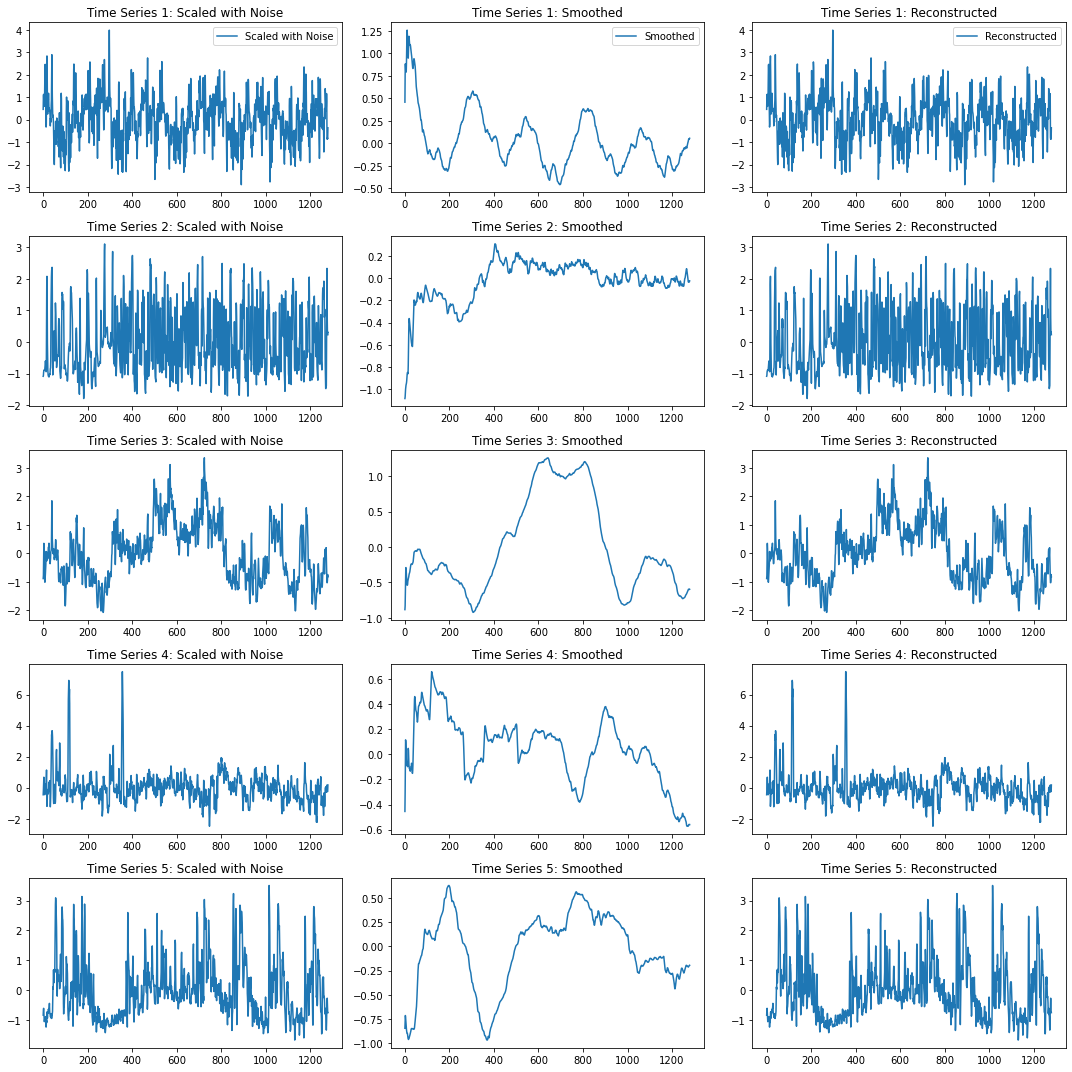

In [14]:
# Plot the scaled time series with noise and the reconstructed time series side by side
num_series_to_plot = (5)  # Plot at most 50 time series or the number available
num_plots = 3  # Three plots per time series: scaled with noise, smoothed, and reconstructed

if num_series_to_plot > 0:
    plt.figure(figsize=(15, num_series_to_plot*3))

    for i in range(num_series_to_plot):
        for j in range(num_plots):
            plt.subplot(num_series_to_plot, num_plots, i * num_plots + j + 1)
            if j == 0:
                plt.plot(best_scaled_series_list[i], label='Scaled with Noise')
                plt.title(f'Time Series {i+1}: Scaled with Noise')
            elif j == 1:
                plt.plot(best_smoothed_series_list[i], label='Smoothed')
                plt.title(f'Time Series {i+1}: Smoothed')
            else:
                plt.plot(best_original_series_list[i], label='Reconstructed')
                plt.title(f'Time Series {i+1}: Reconstructed')
            if i == 0:
                plt.legend()

    plt.tight_layout()
    plt.show()
else:
    print("No time series available for plotting.")


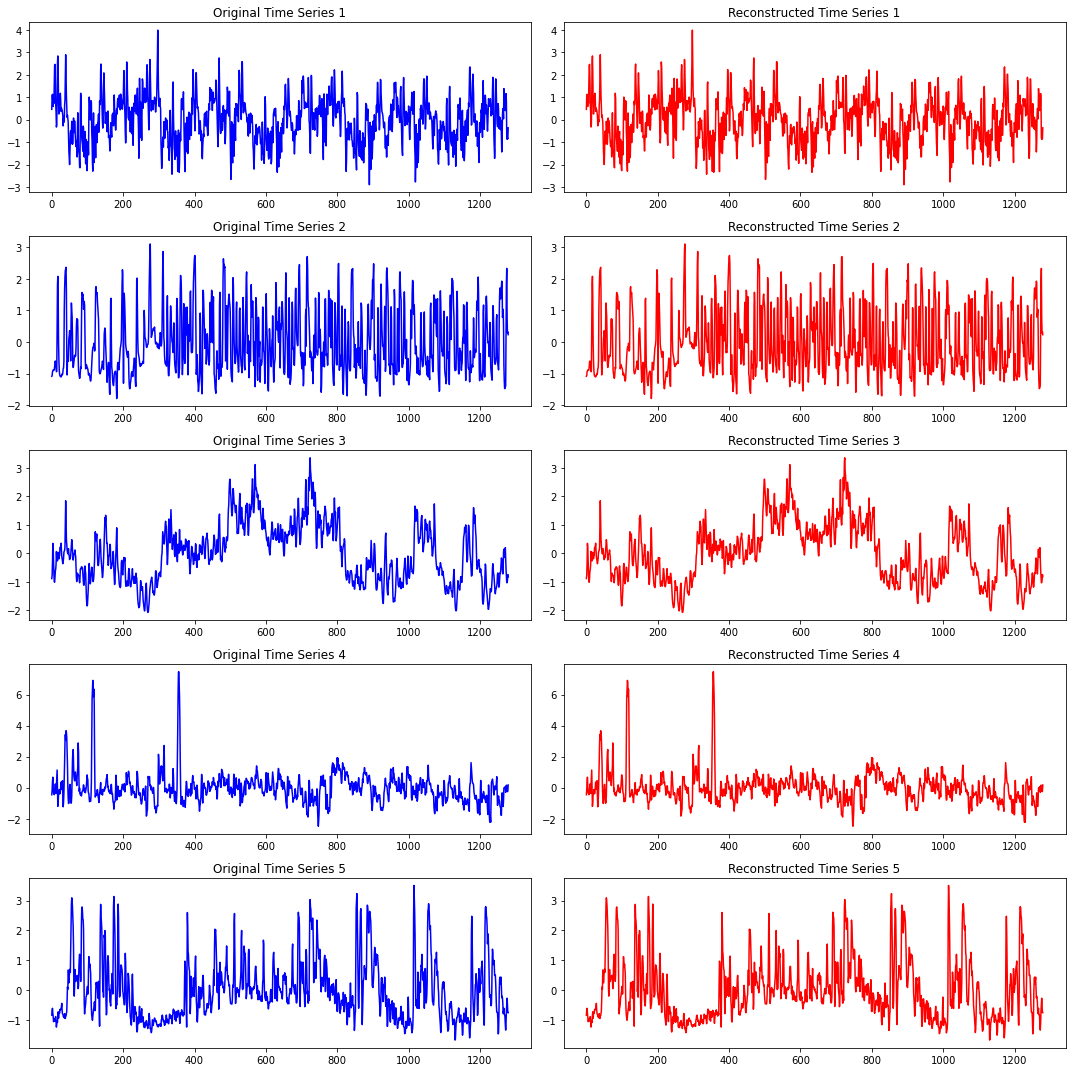

In [15]:
import matplotlib.pyplot as plt

# Assuming original_series_list contains the reconstructed original time series
# and X contains the original time series data

# Plotting the time series side by side
num_samples = 5  # Number of time series to plot

fig, axs = plt.subplots(num_samples, 2, figsize=(15, num_samples*3))

for i in range(num_samples):
    # Original time series
    axs[i, 0].plot(best_scaled_series_list[i], color='blue', label='Original')
    axs[i, 0].set_title('Original Time Series ' + str(i+1))
    
    # Reconstructed time series
    axs[i, 1].plot(best_original_series_list[i], color='red', label='Reconstructed')
    axs[i, 1].set_title('Reconstructed Time Series ' + str(i+1))

plt.tight_layout()
plt.show()


# Find best PAA intervals

The best interval value is: 160
Minimum euclidean distance: 1.0649037848419058


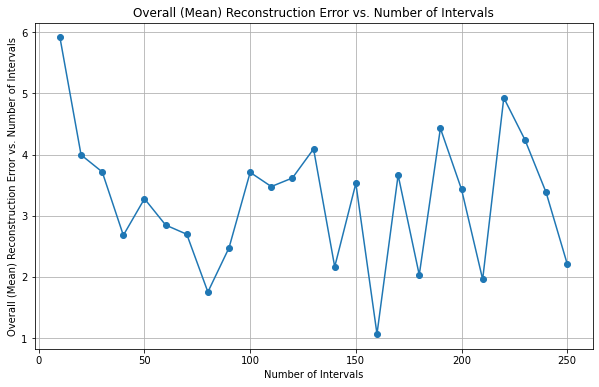

In [16]:
from tslearn.piecewise import PiecewiseAggregateApproximation
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import euclidean

# Define a function to calculate Euclidean distance
def calculate_euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

# Initialize a list to store average distances for different values of num_intervals
avg_distances = []

# Initialize a list to store the distances for the best interval
distances_for_best_interval = []

# Iterate over each time series in X
for series_list in X:

    # Initialize a list to store average distances for different values of num_intervals for the current series
    avg_distances_series = []

    # Try different values of num_intervals
    for num_intervals in range(10, 251, 10):  # Try intervals from 10 to 250

        # Select the first time series
        ts = series_list[0]  # Assuming each series_list contains a single time series

        # Scale the time series
        tss = scaler.fit_transform(np.array(ts).reshape(-1, 1))

        # Mean centering and standardization (amplitude scaling)
        ts_scaled = ((tss - tss.mean()) / tss.std())

        # Apply rolling window mean (noise)
        ts_smoothed = pd.Series(ts_scaled.squeeze()).rolling(window=w, min_periods=1).mean()

        # New dataframe for ts_smoothed
        df = pd.DataFrame(ts_smoothed)
        df_values = df.values.reshape(1, -1, 1)  # Reshape to 3D array (n_samples, n_timestamps, n_features)

        # Perform Piecewise Aggregate Approximation (PAA)
        paa = PiecewiseAggregateApproximation(n_segments=num_intervals)
        ts_paa = paa.fit_transform(df_values)

        # Invert PAA transformation
        inverse_paa = paa.inverse_transform(ts_paa)

        # Invert scaling transformation
        reconstructed_series = inverse_paa.squeeze()

        # Calculate Euclidean distance between smoothed and reconstructed time series
        distance = calculate_euclidean_distance(ts_smoothed, reconstructed_series)

        # Append the distance to the list
        avg_distances_series.append(distance)

    # Append the average distances for the current series to the overall list
    avg_distances.append(avg_distances_series)

# Calculate the overall average distances across all time series for each num_intervals
overall_avg_distances = np.mean(avg_distances, axis=0)

# Find the index of the minimum overall average Euclidean distance
best_interval_index = np.argmin(overall_avg_distances)

# Calculate the corresponding best num_intervals
best_interval = 10 + best_interval_index * 10  # Because the intervals start from 10 and increase by 10

# Obtain the minimum Euclidean distance
min_euclidean_distance = overall_avg_distances[best_interval_index]

# Print the best interval value and the corresponding minimum Euclidean distance
print("The best interval value is:", best_interval)
print("Minimum euclidean distance:", min_euclidean_distance)

# Plot the overall average distances for different values of num_intervals
plt.figure(figsize=(10, 6))
plt.plot(range(10, 251, 10), overall_avg_distances, marker='o', linestyle='-')
plt.title('Overall (Mean) Reconstruction Error vs. Number of Intervals')
plt.xlabel('Number of Intervals')
plt.ylabel('Overall (Mean) Reconstruction Error vs. Number of Intervals')
plt.grid(True)
plt.show()


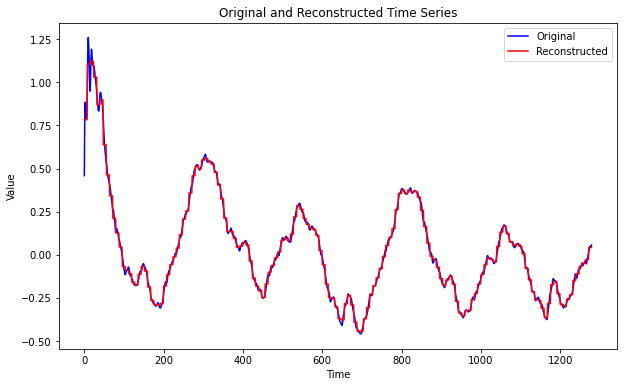

In [17]:
# Define window size for rolling mean
w = 150  # Best value from previous studies

# best value from previous studies
num_intervals = 160

# Select one time series from X
ts = X[0][0]  # Assuming X is a list of lists where each inner list contains a single time series

# Initialize scaler
scaler = StandardScaler()

# Scale the time series
tss = scaler.fit_transform(np.array(ts).reshape(-1, 1))

# Mean centering and standardization (amplitude scaling)
ts_scaled = ((tss - tss.mean()) / tss.std())

# Apply rolling window mean (noise)
ts_smoothed = pd.Series(ts_scaled.squeeze()).rolling(window=w, min_periods=1).mean()

# New dataframe for ts_smoothed
df = pd.DataFrame(ts_smoothed)
df_values = df.values.reshape(1, -1, 1)  # Reshape to 3D array (n_samples, n_timestamps, n_features)

# Perform Piecewise Aggregate Approximation (PAA)
paa = PiecewiseAggregateApproximation(n_segments=num_intervals)
ts_paa = paa.fit_transform(df_values)

# Invert PAA transformation
inverse_paa = paa.inverse_transform(ts_paa)

# Invert scaling transformation
reconstructed_series = inverse_paa.squeeze()

# Plot original and reconstructed time series
plt.figure(figsize=(10, 6))
plt.plot(ts_smoothed, label='Original', color='blue')
plt.plot(reconstructed_series, label='Reconstructed', color='red')
plt.title('Original and Reconstructed Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


# Preprocess TS with best values so far

In [18]:
w=150 
best_intervals=160 # from past studies
ts_paa_list = []

for i in range(len(X)):
        ts = X[i][0]  # Assuming X is a list of lists where each inner list contains a single time series

        # Scale the time series
        tss = scaler.fit_transform(np.array(ts).reshape(-1, 1))

        # Mean centering and standardization (amplitude scaling)
        ts_scaled = ((tss - tss.mean()) / tss.std())

        # Apply rolling window mean (noise)
        ts_smoothed = pd.Series(ts_scaled.squeeze()).rolling(window=w, min_periods=1).mean()

        # Perform Piecewise Aggregate Approximation (PAA)
        paa = PAA(num_intervals=best_intervals)
        ts_paa = paa.fit_transform(pd.DataFrame(ts_smoothed)).iloc[:, 0].values
        ts_paa_list.append([ts_paa])

# Clustering DTW, silhouette: 0.11

In [19]:
from sktime.clustering.k_means import TimeSeriesKMeans
from sktime.utils.plotting import plot_series

In [20]:
clusterer = TimeSeriesKMeans(n_clusters=2, metric="dtw", distance_params={"itakura_max_slope": 1.0}, verbose=True)

In [21]:
len(ts_paa_list)

2000

In [22]:
ts_paa_vect = np.array(ts_paa_list)

In [23]:
ts_paa_vect.shape

(2000, 1, 160)

In [24]:
clusterer

TimeSeriesKMeans(distance_params={'itakura_max_slope': 1.0}, n_clusters=2,
                 verbose=True)

In [25]:
x_train = ts_paa_vect

In [26]:
len(x_train)

2000

In [27]:
y_train = ts_paa_vect[0][0]

In [28]:
y_train.shape

(160,)

In [29]:
%%time
clusterer.fit(x_train)

Iteration 0, inertia 40465.774976031134.
Iteration 1, inertia 30851.40276817462.
Iteration 2, inertia 28858.585806126343.
Iteration 3, inertia 28670.575302629222.
Iteration 4, inertia 28630.307344207034.
Iteration 5, inertia 28673.414096929424.
Iteration 6, inertia 28678.788786745903.
Iteration 7, inertia 28691.751172684406.
Iteration 8, inertia 28682.670417490517.
Converged at iteration 9: strict convergence.
Iteration 0, inertia 40253.73623933585.
Iteration 1, inertia 29300.45615194055.
Iteration 2, inertia 28775.6367976083.
Iteration 3, inertia 28735.480535274084.
Iteration 4, inertia 28696.2338671668.
Iteration 5, inertia 28693.909061365557.
Converged at iteration 6: strict convergence.
Iteration 0, inertia 40617.19670359773.
Iteration 1, inertia 34788.97501331956.
Iteration 2, inertia 29402.21532618047.
Iteration 3, inertia 29646.418399472415.
Iteration 4, inertia 29074.394228394136.
Iteration 5, inertia 28709.398614482496.
Iteration 6, inertia 28623.73228528491.
Iteration 7, iner

TimeSeriesKMeans(distance_params={'itakura_max_slope': 1.0}, n_clusters=2,
                 verbose=True)

In [30]:
df = pd.DataFrame(np.squeeze(x_train))
df["cluster"] = clusterer.labels_
df.head()

,0,1,2,3,4,5,6,7,8,9,...,151,152,153,154,155,156,157,158,159,cluster
0,0.783091,1.106006,1.121803,1.029573,0.869934,0.897715,0.638208,0.463041,0.342044,0.210352,...,-0.298197,-0.259748,-0.231501,-0.149064,-0.110456,-0.067939,-0.049378,-0.027181,0.042430,1
1,-1.002561,-0.861353,-0.437074,-0.545754,-0.504463,-0.224416,-0.207274,-0.148802,-0.175580,-0.159884,...,-0.016868,0.002468,-0.032987,-0.049993,-0.060099,-0.061687,0.020073,0.054411,-0.028867,0
2,-0.518692,-0.504395,-0.382522,-0.257542,-0.208631,-0.067014,-0.055775,-0.034670,-0.044993,-0.115984,...,-0.475099,-0.551975,-0.660819,-0.691671,-0.714643,-0.722979,-0.693622,-0.643440,-0.598713,0
3,-0.088000,-0.059609,-0.084224,-0.103554,-0.050518,0.389773,0.326282,0.329276,0.405339,0.465848,...,-0.488597,-0.513359,-0.517786,-0.519544,-0.494835,-0.490085,-0.516220,-0.567483,-0.563293,1
4,-0.793650,-0.914624,-0.937407,-0.868293,-0.851979,-0.815716,-0.615457,-0.254172,-0.142203,-0.080271,...,-0.405682,-0.336083,-0.306600,-0.309747,-0.233940,-0.262744,-0.223935,-0.201609,-0.204926,0


In [31]:
df

,0,1,2,3,4,5,6,7,8,9,...,151,152,153,154,155,156,157,158,159,cluster
0,0.783091,1.106006,1.121803,1.029573,0.869934,0.897715,0.638208,0.463041,0.342044,0.210352,...,-0.298197,-0.259748,-0.231501,-0.149064,-0.110456,-0.067939,-0.049378,-0.027181,0.042430,1
1,-1.002561,-0.861353,-0.437074,-0.545754,-0.504463,-0.224416,-0.207274,-0.148802,-0.175580,-0.159884,...,-0.016868,0.002468,-0.032987,-0.049993,-0.060099,-0.061687,0.020073,0.054411,-0.028867,0
2,-0.518692,-0.504395,-0.382522,-0.257542,-0.208631,-0.067014,-0.055775,-0.034670,-0.044993,-0.115984,...,-0.475099,-0.551975,-0.660819,-0.691671,-0.714643,-0.722979,-0.693622,-0.643440,-0.598713,0
3,-0.088000,-0.059609,-0.084224,-0.103554,-0.050518,0.389773,0.326282,0.329276,0.405339,0.465848,...,-0.488597,-0.513359,-0.517786,-0.519544,-0.494835,-0.490085,-0.516220,-0.567483,-0.563293,1
4,-0.793650,-0.914624,-0.937407,-0.868293,-0.851979,-0.815716,-0.615457,-0.254172,-0.142203,-0.080271,...,-0.405682,-0.336083,-0.306600,-0.309747,-0.233940,-0.262744,-0.223935,-0.201609,-0.204926,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.741950,0.737235,0.868136,1.036199,1.080317,1.132645,1.195065,1.227041,1.236282,1.247508,...,0.345309,0.333684,0.315730,0.265309,0.197428,0.152173,0.125648,0.102585,0.058486,1
1996,-1.235378,-1.157944,-1.237895,-1.261273,-1.281433,-1.215287,-1.260876,-1.298950,-1.318891,-1.336940,...,-0.012788,-0.082946,-0.093661,-0.051565,0.005362,0.003783,0.021219,0.015954,-0.031866,0
1997,0.158295,0.116214,0.044206,0.100986,0.190679,0.190493,0.086354,0.056045,-0.006203,-0.076565,...,0.315784,0.315007,0.326281,0.377210,0.402963,0.284356,0.218052,0.176559,0.157073,0
1998,1.105053,0.984276,0.805387,0.742567,0.652496,0.693522,0.873286,1.021915,1.133419,1.194033,...,0.162985,0.097606,0.069131,0.057366,0.052803,0.034897,0.010264,-0.042232,-0.142409,1


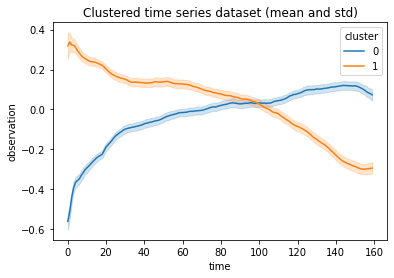

In [32]:
df_melt = df.melt(value_name="observation", var_name="time", id_vars="cluster")
sns.lineplot(df_melt, x="time", y="observation", hue="cluster")
plt.title("Clustered time series dataset (mean and std)")
plt.show()

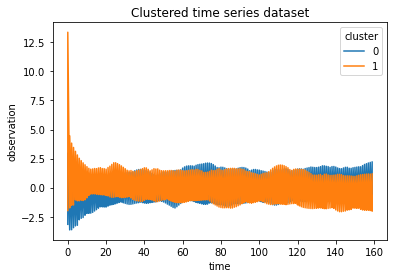

In [33]:
sns.lineplot(df_melt, x="time", y="observation", hue="cluster", estimator=None)
plt.title("Clustered time series dataset")
plt.show()

# Clustering Euclidean Dist, silhouette: 0.13

In [34]:
w=150  # from past studies
best_intervals=160 # from past studies
ts_nopaa_list = []

for i in range(len(X)):
        ts = X[i][0]  # Assuming X is a list of lists where each inner list contains a single time series

        # Scale the time series
        tss = scaler.fit_transform(np.array(ts).reshape(-1, 1))

        # Mean centering and standardization (amplitude scaling)
        ts_scaled = ((tss - tss.mean()) / tss.std())

        # Apply rolling window mean (noise)
        ts_smoothed = pd.Series(ts_scaled.squeeze()).rolling(window=w, min_periods=1).mean()
        ts_nopaa_list.append([ts_smoothed])

In [35]:
ts_nopaa_vect = np.array(ts_nopaa_list)

In [36]:
ts_nopaa_vect.shape

(2000, 1, 1280)

In [37]:
x_train = ts_nopaa_vect

In [38]:
len(x_train)

2000

In [39]:
x_train.shape

(2000, 1, 1280)

In [40]:
y_train = ts_nopaa_vect[0][0]

In [41]:
y_train.shape

(1280,)

215.750 --> 172.727 --> 170.477 --> 168.800 --> 167.577 --> 166.896 --> 166.460 --> 166.210 --> 166.078 --> 166.026 --> 166.002 --> 165.995 --> 165.992 --> 165.990 --> 165.988 --> 165.986 --> 165.984 --> 165.984 --> 165.984 --> 165.983 --> 165.983 --> 165.983 --> 
205.006 --> 158.599 --> 153.805 --> 152.457 --> 151.951 --> 151.772 --> 151.690 --> 151.644 --> 151.626 --> 151.618 --> 151.614 --> 151.613 --> 151.609 --> 151.606 --> 151.605 --> 151.605 --> 151.605 --> 
188.138 --> 153.629 --> 149.338 --> 147.185 --> 145.257 --> 143.830 --> 143.016 --> 142.510 --> 142.216 --> 142.112 --> 142.050 --> 141.999 --> 141.962 --> 141.935 --> 141.923 --> 141.916 --> 141.913 --> 141.913 --> 141.913 --> 141.913 --> 
198.547 --> 147.587 --> 141.535 --> 139.670 --> 138.831 --> 138.318 --> 137.829 --> 137.422 --> 137.163 --> 136.917 --> 136.751 --> 136.564 --> 136.408 --> 136.229 --> 136.082 --> 135.970 --> 135.910 --> 135.883 --> 135.854 --> 135.834 --> 135.817 --> 135.812 --> 135.811 --> 135.809 --> 1

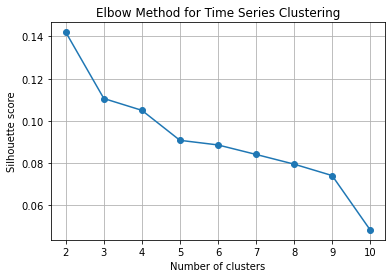

In [42]:
from tslearn.clustering import TimeSeriesKMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score


# Assuming you have your time series data stored in x_train

# Define the range of possible numbers of clusters
n_clusters_range = range(2, 11)  # Assuming you want to test from 2 to 10 clusters

# Initialize lists to store silhouette scores
silhouette_scores = []

# Loop over each possible number of clusters
for n_clusters in n_clusters_range:
    # Instantiate the TimeSeriesKMeans clusterer
    clusterer = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", verbose=True)
    
    # Reshape x_train to comply with the expected shape
    x_train_reshaped = np.reshape(x_train, (x_train.shape[0], x_train.shape[2]))
    
    # Fit the clusterer to your time series data
    cluster_labels = clusterer.fit_predict(x_train_reshaped)
    
    # Calculate silhouette score
    silhouette_avg = silhouette_score(x_train_reshaped, cluster_labels, metric="euclidean")
    silhouette_scores.append(silhouette_avg)

# Plot the elbow method for silhouette scores
plt.figure()
plt.plot(n_clusters_range, silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Elbow Method for Time Series Clustering')
plt.xticks(n_clusters_range)
plt.grid(True)
plt.show()


401.288 --> 170.266 --> 168.437 --> 167.226 --> 166.598 --> 166.313 --> 166.166 --> 166.074 --> 166.034 --> 166.022 --> 166.014 --> 166.010 --> 166.006 --> 166.006 --> 166.004 --> 166.004 --> 166.004 --> 166.004 --> 166.002 --> 166.001 --> 166.000 --> 165.999 --> 165.999 --> 165.999 --> 165.999 --> 
205.589 --> 161.760 --> 157.302 --> 154.438 --> 152.859 --> 152.226 --> 151.950 --> 151.799 --> 151.714 --> 151.662 --> 151.629 --> 151.617 --> 151.612 --> 151.610 --> 151.608 --> 151.607 --> 151.607 --> 
233.320 --> 151.825 --> 147.404 --> 144.553 --> 143.137 --> 142.510 --> 142.204 --> 142.048 --> 141.966 --> 141.950 --> 141.946 --> 141.940 --> 141.936 --> 141.929 --> 141.916 --> 141.915 --> 141.914 --> 141.913 --> 141.912 --> 141.911 --> 141.911 --> 141.911 --> 141.911 --> 141.910 --> 141.908 --> 141.907 --> 141.907 --> 141.906 --> 141.905 --> 141.905 --> 141.905 --> 141.905 --> 
170.965 --> 145.700 --> 142.284 --> 141.231 --> 140.580 --> 139.935 --> 139.316 --> 138.910 --> 138.575 --> 1

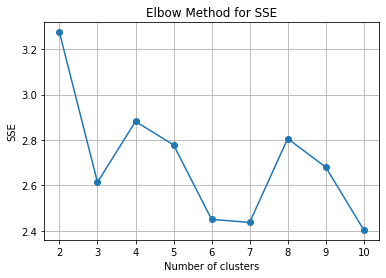

In [43]:
from tslearn.clustering import TimeSeriesKMeans
from sklearn.metrics import pairwise_distances_argmin_min

# Assuming you have your time series data stored in x_train

# Define the range of possible numbers of clusters
n_clusters_range = range(2, 11)  # Assuming you want to test from 2 to 10 clusters

# Initialize a list to store SSE
sse = []

# Reshape x_train to comply with the expected shape
x_train_reshaped = np.reshape(x_train, (x_train.shape[0], -1))

# Loop over each possible number of clusters
for n_clusters in n_clusters_range:
    # Instantiate the TimeSeriesKMeans clusterer
    clusterer = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", verbose=True)
    
    # Fit the clusterer to your time series data
    cluster_labels = clusterer.fit_predict(x_train_reshaped)
    
    # Reshape cluster centers to 2D
    cluster_centers_reshaped = np.reshape(clusterer.cluster_centers_, (n_clusters, -1))
    
    # Calculate SSE
    closest, _ = pairwise_distances_argmin_min(cluster_centers_reshaped, x_train_reshaped)
    sse.append(np.sum(np.min(pairwise_distances_argmin_min(x_train_reshaped, cluster_centers_reshaped), axis=1)))

# Plot the elbow method for SSE
plt.plot(n_clusters_range, sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow Method for SSE')
plt.xticks(n_clusters_range)
plt.grid(True)
plt.show()


In [44]:
from sktime.clustering.k_means import TimeSeriesKMeans
from sktime.utils.plotting import plot_series   # best num clusters is 2
clusterer = TimeSeriesKMeans(n_clusters=2, metric="euclidean", verbose=True)

In [45]:
%%time
clusterer.fit(x_train)

Iteration 0, inertia 25373.83729905286.
Iteration 1, inertia 24013.205095567704.
Iteration 2, inertia 23858.283200853635.
Iteration 3, inertia 23816.3095908841.
Iteration 4, inertia 23796.293975179608.
Iteration 5, inertia 23788.830853208445.
Iteration 6, inertia 23786.860137738426.
Iteration 7, inertia 23786.14884738558.
Iteration 8, inertia 23785.50131686673.
Iteration 9, inertia 23785.388302188963.
Iteration 10, inertia 23785.273599655076.
Converged at iteration 11: strict convergence.
Iteration 0, inertia 25515.48756934049.
Iteration 1, inertia 24303.81142532076.
Iteration 2, inertia 24194.938763585826.
Iteration 3, inertia 24059.275604010058.
Iteration 4, inertia 23948.164850309324.
Iteration 5, inertia 23860.189868289803.
Iteration 6, inertia 23820.872972584388.
Iteration 7, inertia 23798.396815594104.
Iteration 8, inertia 23789.655559459883.
Iteration 9, inertia 23784.847359538166.
Iteration 10, inertia 23782.870703902714.
Iteration 11, inertia 23781.918226228554.
Iteration 12, 

TimeSeriesKMeans(metric='euclidean', n_clusters=2, verbose=True)

In [46]:
df = pd.DataFrame(np.squeeze(x_train))
df["cluster"] = clusterer.labels_
df.head()

,0,1,2,3,4,5,6,7,8,9,...,1271,1272,1273,1274,1275,1276,1277,1278,1279,cluster
0,0.458418,0.763552,0.884972,0.840710,0.790546,0.817947,0.805107,0.903475,1.072168,1.211254,...,0.007590,0.015345,0.028144,0.044043,0.049949,0.048216,0.045997,0.050545,0.057200,1
1,-1.084611,-1.070874,-1.029090,-0.999424,-0.976329,-0.963162,-0.952745,-0.944251,-0.925697,-0.895906,...,0.002565,-0.020010,-0.032489,-0.032980,-0.027954,-0.030094,-0.033590,-0.030406,-0.023413,0
2,-0.884092,-0.831911,-0.661956,-0.408411,-0.291686,-0.290375,-0.350433,-0.430673,-0.495422,-0.530449,...,-0.613866,-0.605516,-0.599025,-0.595435,-0.595797,-0.597675,-0.600134,-0.599607,-0.596514,1
3,-0.455156,-0.303593,-0.073343,0.113826,0.098953,0.025372,-0.028469,-0.081591,-0.088664,-0.089926,...,-0.571140,-0.572646,-0.570591,-0.565517,-0.561149,-0.558287,-0.558179,-0.560090,-0.559884,1
4,-0.845692,-0.763205,-0.714108,-0.733734,-0.767357,-0.816875,-0.846714,-0.861512,-0.877912,-0.894627,...,-0.210274,-0.213492,-0.214005,-0.210952,-0.207775,-0.202588,-0.198439,-0.196993,-0.195166,0


In [47]:
df

,0,1,2,3,4,5,6,7,8,9,...,1271,1272,1273,1274,1275,1276,1277,1278,1279,cluster
0,0.458418,0.763552,0.884972,0.840710,0.790546,0.817947,0.805107,0.903475,1.072168,1.211254,...,0.007590,0.015345,0.028144,0.044043,0.049949,0.048216,0.045997,0.050545,0.057200,1
1,-1.084611,-1.070874,-1.029090,-0.999424,-0.976329,-0.963162,-0.952745,-0.944251,-0.925697,-0.895906,...,0.002565,-0.020010,-0.032489,-0.032980,-0.027954,-0.030094,-0.033590,-0.030406,-0.023413,0
2,-0.884092,-0.831911,-0.661956,-0.408411,-0.291686,-0.290375,-0.350433,-0.430673,-0.495422,-0.530449,...,-0.613866,-0.605516,-0.599025,-0.595435,-0.595797,-0.597675,-0.600134,-0.599607,-0.596514,1
3,-0.455156,-0.303593,-0.073343,0.113826,0.098953,0.025372,-0.028469,-0.081591,-0.088664,-0.089926,...,-0.571140,-0.572646,-0.570591,-0.565517,-0.561149,-0.558287,-0.558179,-0.560090,-0.559884,1
4,-0.845692,-0.763205,-0.714108,-0.733734,-0.767357,-0.816875,-0.846714,-0.861512,-0.877912,-0.894627,...,-0.210274,-0.213492,-0.214005,-0.210952,-0.207775,-0.202588,-0.198439,-0.196993,-0.195166,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.711827,0.765035,0.716457,0.737245,0.743251,0.782511,0.743871,0.735402,0.733434,0.739211,...,0.083029,0.075764,0.069540,0.063860,0.057911,0.052372,0.050055,0.049839,0.048544,1
1996,-1.170652,-1.276372,-1.219136,-1.209011,-1.257231,-1.250904,-1.258167,-1.241547,-1.196434,-1.180122,...,0.004930,-0.004890,-0.016677,-0.024322,-0.031252,-0.035664,-0.039082,-0.048671,-0.054373,0
1997,-0.450441,-0.372219,0.105771,0.391983,0.425899,0.423744,0.393140,0.348486,0.209980,0.125819,...,0.171382,0.172981,0.172523,0.167564,0.159126,0.151777,0.148244,0.143576,0.140795,0
1998,0.660472,0.908718,1.114568,1.208428,1.263786,1.271290,1.230899,1.182262,1.139918,1.110424,...,-0.076124,-0.089765,-0.106559,-0.122895,-0.136588,-0.150393,-0.164652,-0.178237,-0.190185,1


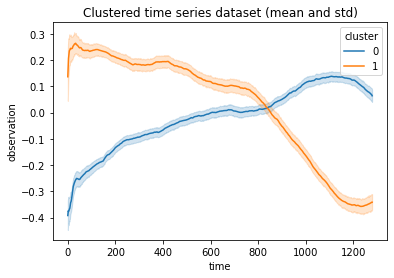

In [48]:
df_melt = df.melt(value_name="observation", var_name="time", id_vars="cluster")
sns.lineplot(df_melt, x="time", y="observation", hue="cluster")
plt.title("Clustered time series dataset (mean and std)")
plt.show()

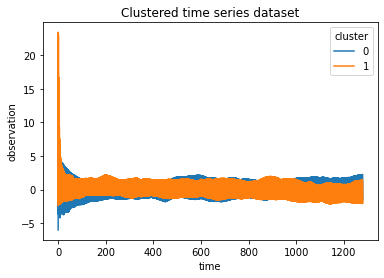

In [49]:
sns.lineplot(df_melt, x="time", y="observation", hue="cluster", estimator=None)
plt.title("Clustered time series dataset")
plt.show()

# Explore and analysis with PCA

In [50]:
cluster_0 = df[df["cluster"] == 0]

In [51]:
cluster_0

,0,1,2,3,4,5,6,7,8,9,...,1271,1272,1273,1274,1275,1276,1277,1278,1279,cluster
1,-1.084611,-1.070874,-1.029090,-0.999424,-0.976329,-0.963162,-0.952745,-0.944251,-0.925697,-0.895906,...,0.002565,-0.020010,-0.032489,-0.032980,-0.027954,-0.030094,-0.033590,-0.030406,-0.023413,0
4,-0.845692,-0.763205,-0.714108,-0.733734,-0.767357,-0.816875,-0.846714,-0.861512,-0.877912,-0.894627,...,-0.210274,-0.213492,-0.214005,-0.210952,-0.207775,-0.202588,-0.198439,-0.196993,-0.195166,0
7,0.061223,0.056819,0.005696,-0.087819,-0.169306,-0.237783,-0.267882,-0.269952,-0.303513,-0.337909,...,0.371277,0.374993,0.379219,0.382819,0.385383,0.388960,0.391310,0.390512,0.385997,0
8,0.658544,0.717499,0.714988,0.710279,0.700325,0.668996,0.636916,0.592015,0.539646,0.482116,...,-0.083300,-0.114445,-0.153669,-0.196784,-0.239532,-0.281262,-0.318940,-0.348016,-0.370691,0
10,0.219594,0.161711,0.166461,0.275584,0.382484,0.443885,0.496302,0.538143,0.560718,0.570662,...,0.390590,0.418267,0.445490,0.467646,0.482641,0.502341,0.521847,0.532656,0.534205,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1992,2.323094,1.132114,0.371753,-0.002611,0.190502,0.421266,0.304277,0.186538,0.199189,0.156035,...,-0.059347,-0.058759,-0.062245,-0.069097,-0.068847,-0.072195,-0.073697,-0.070028,-0.070670,0
1993,0.534993,0.433932,0.642297,1.096574,1.246332,1.108324,0.859526,0.632625,0.432930,0.291990,...,-0.077598,-0.080455,-0.077247,-0.066424,-0.050813,-0.040449,-0.034092,-0.031615,-0.025676,0
1994,2.147236,1.559367,1.188746,0.985235,0.952403,0.758510,0.799687,0.877942,0.868298,0.889805,...,-0.127304,-0.130183,-0.137405,-0.148055,-0.149669,-0.141668,-0.136861,-0.141478,-0.147572,0
1996,-1.170652,-1.276372,-1.219136,-1.209011,-1.257231,-1.250904,-1.258167,-1.241547,-1.196434,-1.180122,...,0.004930,-0.004890,-0.016677,-0.024322,-0.031252,-0.035664,-0.039082,-0.048671,-0.054373,0


In [52]:
cluster_1 = df[df["cluster"] == 1]

In [53]:
cluster_1

,0,1,2,3,4,5,6,7,8,9,...,1271,1272,1273,1274,1275,1276,1277,1278,1279,cluster
0,0.458418,0.763552,0.884972,0.840710,0.790546,0.817947,0.805107,0.903475,1.072168,1.211254,...,0.007590,0.015345,0.028144,0.044043,0.049949,0.048216,0.045997,0.050545,0.057200,1
2,-0.884092,-0.831911,-0.661956,-0.408411,-0.291686,-0.290375,-0.350433,-0.430673,-0.495422,-0.530449,...,-0.613866,-0.605516,-0.599025,-0.595435,-0.595797,-0.597675,-0.600134,-0.599607,-0.596514,1
3,-0.455156,-0.303593,-0.073343,0.113826,0.098953,0.025372,-0.028469,-0.081591,-0.088664,-0.089926,...,-0.571140,-0.572646,-0.570591,-0.565517,-0.561149,-0.558287,-0.558179,-0.560090,-0.559884,1
5,-1.049534,-1.042774,-1.023385,-1.007057,-0.988443,-0.976125,-0.975269,-0.978339,-0.980882,-0.986874,...,-0.545678,-0.541130,-0.535794,-0.530144,-0.523707,-0.516818,-0.512351,-0.508579,-0.504896,1
6,-0.819785,-0.803191,-0.758424,-0.708961,-0.653346,-0.635970,-0.643559,-0.641498,-0.628043,-0.602052,...,-0.521777,-0.506884,-0.495183,-0.485321,-0.477518,-0.471226,-0.466194,-0.462795,-0.463153,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1985,-0.625940,-0.623816,-0.725402,-0.784247,-0.766984,-0.685759,-0.637775,-0.591416,-0.557629,-0.534388,...,-0.489340,-0.517424,-0.545466,-0.564712,-0.571573,-0.575605,-0.582141,-0.587917,-0.592226,1
1989,1.948488,2.228178,2.100912,1.532748,1.391615,1.488962,1.442312,1.258533,1.094058,0.920892,...,-0.207420,-0.195226,-0.191157,-0.197761,-0.201624,-0.206497,-0.210251,-0.222344,-0.228413,1
1995,0.711827,0.765035,0.716457,0.737245,0.743251,0.782511,0.743871,0.735402,0.733434,0.739211,...,0.083029,0.075764,0.069540,0.063860,0.057911,0.052372,0.050055,0.049839,0.048544,1
1998,0.660472,0.908718,1.114568,1.208428,1.263786,1.271290,1.230899,1.182262,1.139918,1.110424,...,-0.076124,-0.089765,-0.106559,-0.122895,-0.136588,-0.150393,-0.164652,-0.178237,-0.190185,1


In [54]:
cluster_0.describe()

,0,1,2,3,4,5,6,7,8,9,...,1271,1272,1273,1274,1275,1276,1277,1278,1279,cluster
count,1151.000000,1151.000000,1151.000000,1151.000000,1151.000000,1151.000000,1151.000000,1151.000000,1151.000000,1151.000000,...,1151.000000,1151.000000,1151.000000,1151.000000,1151.000000,1151.000000,1151.000000,1151.000000,1151.000000,1151.0
mean,-0.391852,-0.383888,-0.373921,-0.376165,-0.375686,-0.372270,-0.367635,-0.366149,-0.365675,-0.361279,...,0.073554,0.072715,0.071717,0.070573,0.069474,0.068521,0.067608,0.066347,0.064163,0.0
std,0.964722,0.926067,0.892828,0.862762,0.837322,0.814510,0.793423,0.776153,0.757405,0.734354,...,0.412655,0.413715,0.414917,0.416270,0.417685,0.419083,0.420468,0.422032,0.423754,0.0
min,-5.979402,-3.640382,-3.190342,-3.011019,-3.355482,-3.678180,-3.915200,-4.080320,-4.192935,-3.950636,...,-1.392418,-1.417717,-1.439258,-1.451752,-1.468447,-1.500613,-1.536644,-1.569986,-1.600170,0.0
25%,-1.029854,-0.993985,-0.933538,-0.933480,-0.920147,-0.907423,-0.896363,-0.870643,-0.849326,-0.836706,...,-0.145178,-0.148255,-0.152464,-0.153979,-0.156435,-0.154989,-0.153935,-0.153254,-0.158295,0.0
50%,-0.467939,-0.478327,-0.477731,-0.469393,-0.461666,-0.449497,-0.446149,-0.425279,-0.409130,-0.417476,...,0.052147,0.054146,0.056280,0.056440,0.052694,0.050398,0.047708,0.044750,0.041641,0.0
75%,0.097347,0.091581,0.120188,0.097742,0.095602,0.089261,0.074274,0.064622,0.046522,0.049452,...,0.272390,0.272502,0.272138,0.273373,0.274259,0.270722,0.270033,0.269906,0.268758,0.0
max,4.314513,4.532384,4.783274,4.969901,5.093287,5.064932,4.951967,4.824290,4.588667,4.351858,...,2.183688,2.188169,2.192879,2.198580,2.202422,2.201705,2.204051,2.223378,2.241250,0.0


In [55]:
cluster_1.describe()

,0,1,2,3,4,5,6,7,8,9,...,1271,1272,1273,1274,1275,1276,1277,1278,1279,cluster
count,849.000000,849.000000,849.000000,849.000000,849.000000,849.000000,849.000000,849.000000,849.000000,849.000000,...,849.000000,849.000000,849.000000,849.000000,849.000000,849.000000,849.000000,849.000000,849.000000,849.0
mean,0.136430,0.160424,0.190150,0.205732,0.215066,0.224580,0.231542,0.236373,0.237533,0.238975,...,-0.345215,-0.344701,-0.344027,-0.343473,-0.342903,-0.342144,-0.341255,-0.340758,-0.341079,1.0
std,1.507544,1.396259,1.233202,1.115743,1.036311,0.970672,0.920645,0.879495,0.843383,0.813528,...,0.448163,0.449079,0.450225,0.451442,0.452592,0.453739,0.454938,0.456378,0.457914,0.0
min,-2.363840,-2.167999,-2.109936,-2.130145,-2.144131,-2.152423,-2.153553,-2.153788,-2.147095,-2.130808,...,-1.986095,-1.991269,-1.996862,-2.003825,-2.013683,-2.024398,-2.035891,-2.047784,-2.056394,1.0
25%,-0.528237,-0.505548,-0.457564,-0.466976,-0.462320,-0.427756,-0.373851,-0.344040,-0.341969,-0.314682,...,-0.574849,-0.572343,-0.569017,-0.568479,-0.571573,-0.569704,-0.563988,-0.562832,-0.570250,1.0
50%,-0.022938,0.000420,0.054050,0.100837,0.128245,0.126158,0.151767,0.160371,0.160879,0.146684,...,-0.301845,-0.299771,-0.301286,-0.301890,-0.300255,-0.297442,-0.292823,-0.294207,-0.294464,1.0
75%,0.559807,0.601029,0.687930,0.680044,0.683481,0.665896,0.654966,0.662499,0.670381,0.662421,...,-0.065311,-0.065748,-0.062196,-0.065443,-0.058822,-0.056489,-0.057653,-0.059504,-0.057792,1.0
max,23.381067,22.976995,16.700801,13.734175,11.501420,9.357034,7.588991,6.430215,5.765414,5.206203,...,1.366314,1.373046,1.379653,1.386386,1.393130,1.399126,1.401475,1.397325,1.384698,1.0


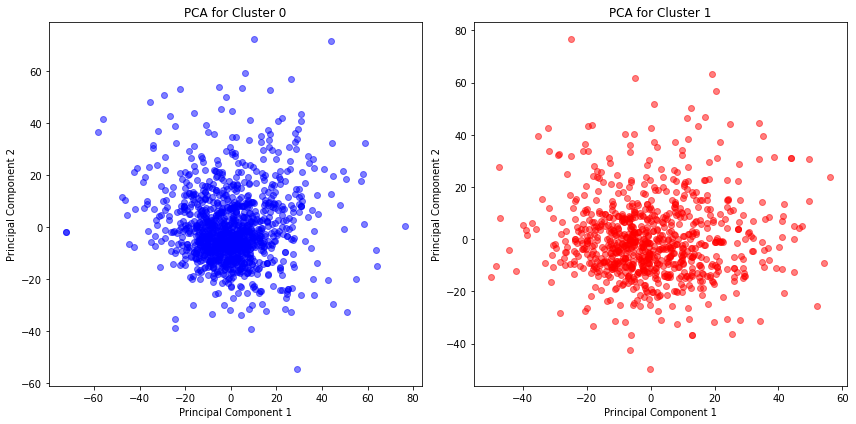

In [56]:
from sklearn.decomposition import PCA

# Assuming cluster_0 and cluster_1 are your dataframes containing the clustered data

# Convert column names to strings
cluster_0.columns = cluster_0.columns.astype(str)
cluster_1.columns = cluster_1.columns.astype(str)



# Apply PCA separately to each cluster

# PCA for Cluster 0
pca_cluster_0 = PCA(n_components=2)  # Specify the number of components as needed
scaled_cluster_0 = StandardScaler().fit_transform(cluster_0)  # Scale the data
pca_result_cluster_0 = pca_cluster_0.fit_transform(scaled_cluster_0)

# PCA for Cluster 1
pca_cluster_1 = PCA(n_components=2)  # Specify the number of components as needed
scaled_cluster_1 = StandardScaler().fit_transform(cluster_1)  # Scale the data
pca_result_cluster_1 = pca_cluster_1.fit_transform(scaled_cluster_1)


# Visualization
plt.figure(figsize=(12, 6))

# Plot PCA for Cluster 0
plt.subplot(1, 2, 1)
plt.scatter(pca_result_cluster_0[:, 0], pca_result_cluster_0[:, 1], c='blue', alpha=0.5)
plt.title('PCA for Cluster 0')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Plot PCA for Cluster 1
plt.subplot(1, 2, 2)
plt.scatter(pca_result_cluster_1[:, 0], pca_result_cluster_1[:, 1], c='red', alpha=0.5)
plt.title('PCA for Cluster 1')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')


plt.tight_layout()
plt.show()


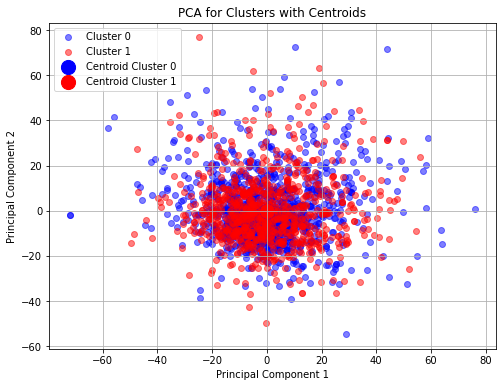

In [57]:
# Calculate centroids for each cluster
centroid_cluster_0 = np.mean(pca_result_cluster_0, axis=0)
centroid_cluster_1 = np.mean(pca_result_cluster_1, axis=0)


# Visualization
plt.figure(figsize=(8, 6))

# Plot PCA for Cluster 0
plt.scatter(pca_result_cluster_0[:, 0], pca_result_cluster_0[:, 1], c='blue', alpha=0.5, label='Cluster 0')

# Plot PCA for Cluster 1
plt.scatter(pca_result_cluster_1[:, 0], pca_result_cluster_1[:, 1], c='red', alpha=0.5, label='Cluster 1')


# Plot centroids
plt.scatter(centroid_cluster_0[0], centroid_cluster_0[1], marker='o', color='blue', s=200, label='Centroid Cluster 0')
plt.scatter(centroid_cluster_1[0], centroid_cluster_1[1], marker='o', color='red', s=200, label='Centroid Cluster 1')



plt.title('PCA for Clusters with Centroids')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()

In [58]:

# Assuming pca_result_cluster_0 and pca_result_cluster_1 are the PCA results for each cluster

# Concatenate the PCA results for both clusters
pca_results = np.concatenate((pca_result_cluster_0, pca_result_cluster_1), axis=0)

# Create labels for each data point indicating the cluster it belongs to
labels = np.array([0] * len(pca_result_cluster_0) + [1] * len(pca_result_cluster_1))

# Calculate silhouette score
silhouette = silhouette_score(pca_results, labels)
print("Silhouette Score:", silhouette)


Silhouette Score: 0.006633635819788978


In [59]:
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Assuming cluster_0, cluster_1, cluster_2, and cluster_3 are your dataframes containing the clustered data

# Concatenate all clusters into a single dataframe
all_clusters = pd.concat([cluster_0, cluster_1])

# Standardize the data
scaled_data = StandardScaler().fit_transform(all_clusters)

# Create labels for each data point based on cluster membership
labels = np.concatenate([np.zeros(len(cluster_0)), np.ones(len(cluster_1))])

# Compute silhouette score
silhouette_avg = silhouette_score(scaled_data, labels)
print("Overall silhouette score:", silhouette_avg)


Overall silhouette score: 0.1316334017596896


In [60]:
# Get explained variance ratio for each principal component
explained_variance_ratio_cluster_0 = pca_cluster_0.explained_variance_ratio_
explained_variance_ratio_cluster_1 = pca_cluster_1.explained_variance_ratio_


# Print explained variance ratio for each cluster
print("Explained Variance Ratio for Cluster 0:")
print(explained_variance_ratio_cluster_0)
print("Total Variance Explained by Cluster 0:", np.sum(explained_variance_ratio_cluster_0))

print("\nExplained Variance Ratio for Cluster 1:")
print(explained_variance_ratio_cluster_1)
print("Total Variance Explained by Cluster 1:", np.sum(explained_variance_ratio_cluster_1))



Explained Variance Ratio for Cluster 0:
[0.20822222 0.1682939 ]
Total Variance Explained by Cluster 0: 0.37651611912106386

Explained Variance Ratio for Cluster 1:
[0.21894349 0.18171541]
Total Variance Explained by Cluster 1: 0.4006588991787253


In [61]:
from sklearn.metrics import euclidean_distances

# Assuming pca_result_cluster_0 and pca_result_cluster_1 are the PCA results for each cluster
# Assuming centroid_cluster_0 and centroid_cluster_1 are the centroids of each cluster

# Calculate distances of each data point to the centroid for Cluster 0
distances_cluster_0 = euclidean_distances(pca_result_cluster_0, [centroid_cluster_0])

# Calculate distances of each data point to the centroid for Cluster 1
distances_cluster_1 = euclidean_distances(pca_result_cluster_1, [centroid_cluster_1])

# Set a threshold for outlier detection (e.g., based on a certain percentile of distances)
threshold = np.percentile(np.concatenate((distances_cluster_0, distances_cluster_1)), 95)

# Find outliers for Cluster 0
outliers_cluster_0 = pca_result_cluster_0[np.where(distances_cluster_0 > threshold)[0]]

# Find outliers for Cluster 1
outliers_cluster_1 = pca_result_cluster_1[np.where(distances_cluster_1 > threshold)[0]]

print("Number of outliers in Cluster 0:", outliers_cluster_0.shape[0])
print("Number of outliers in Cluster 1:", outliers_cluster_1.shape[0])


Number of outliers in Cluster 0: 59
Number of outliers in Cluster 1: 41


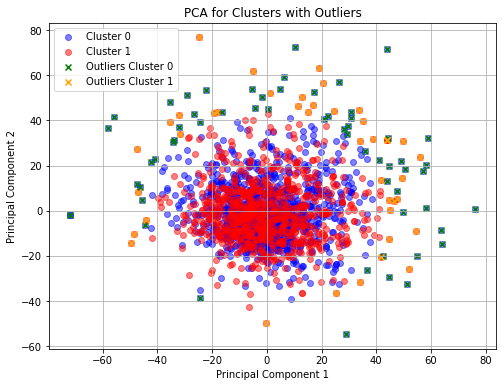

In [62]:
# Visualization
plt.figure(figsize=(8, 6))

# Plot PCA for Cluster 0
plt.scatter(pca_result_cluster_0[:, 0], pca_result_cluster_0[:, 1], c='blue', alpha=0.5, label='Cluster 0')

# Plot PCA for Cluster 1
plt.scatter(pca_result_cluster_1[:, 0], pca_result_cluster_1[:, 1], c='red', alpha=0.5, label='Cluster 1')

# Plot outliers for Cluster 0
plt.scatter(outliers_cluster_0[:, 0], outliers_cluster_0[:, 1], c='green', marker='x', label='Outliers Cluster 0')

# Plot outliers for Cluster 1
plt.scatter(outliers_cluster_1[:, 0], outliers_cluster_1[:, 1], c='orange', marker='x', label='Outliers Cluster 1')

plt.title('PCA for Clusters with Outliers')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()

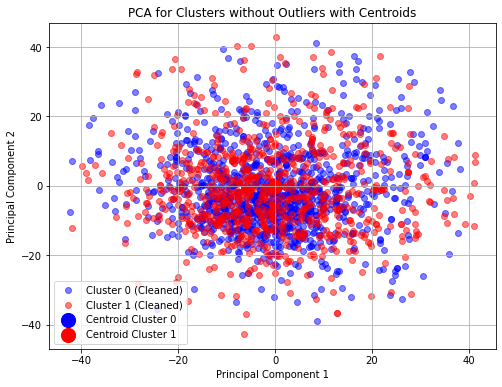

In [63]:
# Assuming pca_result_cluster_0 and pca_result_cluster_1 are the PCA results for each cluster
# Assuming outliers_cluster_0 and outliers_cluster_1 are the outliers for each cluster
# Assuming centroid_cluster_0 and centroid_cluster_1 are the centroids of each cluster

# Remove outliers from the original PCA results
cleaned_pca_result_cluster_0 = np.array([x for x in pca_result_cluster_0 if x not in outliers_cluster_0])
cleaned_pca_result_cluster_1 = np.array([x for x in pca_result_cluster_1 if x not in outliers_cluster_1])

# Visualization
plt.figure(figsize=(8, 6))

# Plot PCA for Cluster 0 without outliers
plt.scatter(cleaned_pca_result_cluster_0[:, 0], cleaned_pca_result_cluster_0[:, 1], c='blue', alpha=0.5, label='Cluster 0 (Cleaned)')

# Plot PCA for Cluster 1 without outliers
plt.scatter(cleaned_pca_result_cluster_1[:, 0], cleaned_pca_result_cluster_1[:, 1], c='red', alpha=0.5, label='Cluster 1 (Cleaned)')

# Plot centroids
plt.scatter(centroid_cluster_0[0], centroid_cluster_0[1], marker='o', color='blue', s=200, label='Centroid Cluster 0')
plt.scatter(centroid_cluster_1[0], centroid_cluster_1[1], marker='o', color='red', s=200, label='Centroid Cluster 1')

plt.title('PCA for Clusters without Outliers with Centroids')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()
